# Conv Params
## Obtaining data
To obtain data required for this script, must run `./load_ds_quant.py` for both `land` and `aquaplanet` in tropics with `daily_max=False`.

In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
from isca_tools.thesis.adiabat_theory2 import get_cape_approx
from isca_tools.thesis.lapse_integral import integral_and_error_calc
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx, get_lnb_ind, parcel_fitting
from isca_tools.thesis.lapse_theory import get_var_at_plev, _get_var_at_plev
from isca_tools.thesis.mod_parcel_theory import get_scale_factor_theory_numerical, get_temp_mod_parcel
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile, lcl_sigma_bolton_simple
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils

from isca_tools.utils.xarray import wrap_with_apply_ufunc

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

In [3]:
print('LCL Bolton Calc Sensitivity')
for var2 in [0.25, 0.5, 0.75]:
    for var in [290, 300, 310]:
        print(var2, var, f"{lcl_sigma_bolton_simple(var2, var):.3f}")

print('\\nu value for T=300: ', np.log(lcl_sigma_bolton_simple(var2, 300)) / np.log(var2))

LCL Bolton Calc Sensitivity
0.25 290 0.722
0.25 300 0.710
0.25 310 0.699
0.5 290 0.850
0.5 300 0.843
0.5 310 0.836
0.75 290 0.935
0.75 300 0.932
0.75 310 0.928
\nu value for T=300:  0.246581572769953


## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [4]:
from jobs.theory_lapse.isca.thesis_figs.load_ds_quant import get_ds, get_P

ds = get_ds(const_layer1_method='optimal')
for key in ds:
    ds[key] = ds[key].sel(p_ft=500 * 100)

## Example Days
#### Aquaplanet
Below I show example days to indicate why simple CAPE increases so much for the coldest days.
This also introduces `mod_parcel` framework, and shows two days where it is better than `const_lapse`.

#### Land
This is to show an example day which is undergoing shallow convection, and `const_lapse` is better than `modParc`, so non-convective day.

In [87]:
%%capture cap
lat_plot = 18
surf_plot = 'aquaplanet'
sample_plot_ind = {'aquaplanet': [79, 64],
                   'land': [6, 21]}  # Good examples with convflag = 2 and lower mod_parcel error
# sample_plot_ind = [6, 21] # Good examples with convflag = 2 and lower mod_parcel error
quant_plot = 0
show_lcl_markers = True
leg_handlelength = 1.4

fig, ax = plt.subplots(ds['aquaplanet'].tau_lw.size, len(ds), sharey=True, sharex=True)
fig_resize(fig, width['two_col'])
for j, surf_plot in enumerate(sample_plot_ind):
    ax[0, j].set_title(f"{surf_plot.capitalize()}\n$\kappa={ds[surf_plot].tau_lw[0]:.1f}$", y=0.9, fontweight='bold')
    ax[1, j].set_title(f"$\kappa={ds[surf_plot].tau_lw[1]:.1f}$", y=0.95)
    for i in range(ds['aquaplanet'].tau_lw.size):
        ds_plot = ds[surf_plot].sel(lat=lat_plot, method='nearest').isel(tau_lw=i).sel(quant=quant_plot, method='nearest')
        # ds_plot = ds_plot.mean(dim='sample')
        # ds_plot.attrs = ds['land'].attrs
        # print(np.where((ds_plot.convflag>=2) & (ds_plot.mod_parcel1_error.sum(dim='layer') < ds_plot.const1_error.sum(dim='layer')))[0][[1, 6][j]])   # how I got sample inds for aquaplanet
        # print(np.where((ds_plot.convflag<=1) & (ds_plot.mod_parcel1_error.sum(dim='layer') > ds_plot.const1_error.sum(dim='layer')) &
        #                (np.abs(ds_plot.mod_parcel1_error.sum(dim='layer')/ds_plot.mod_parcel1_integral.sum(dim='layer'))>0.25))[0])   # how I got sample inds for land
        ds_plot = ds_plot.isel(sample=sample_plot_ind[surf_plot][i])

        ds_plot['lnb_ind'] = get_tropopause_lev_ind(ds_plot.T, ds_plot.Z3, get_P(ds_plot))
        p_thresh = float(get_P(ds_plot).isel(lev=ds_plot.lnb_ind) - 1)
        p_thresh = 0

        ds_plot['p_lcl'] = lcl_sigma_bolton_simple(ds_plot.rh_REFHT, ds_plot.temp_surf_lcl_calc) * ds_plot.PREFHT
        ds_plot['T_lcl_env'] = get_var_at_plev(ds_plot.T, get_P(ds_plot), ds_plot.p_lcl)

        p_use, temp_env_use = insert_to_array(get_P(ds_plot).to_numpy(), ds_plot.T.to_numpy(),
                                              [float(ds_plot.p_lcl), ds_plot.p_ft],
                                              [float(ds_plot.T_lcl_env), float(ds_plot.T_ft_env)])
        use_lev = p_use >= p_thresh
        ax[i, j].plot(temp_env_use[use_lev], np.log10(p_use)[use_lev], color='k',
                   label='$T_{\\text{env}}$' if j == 0 else None)

        T_parcel_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                               float(ds_plot.rh_REFHT),
                                               lapse_dry, 0,
                                               method_layer2='mod_parcel', temp_lower_lcl_calc=ds_plot.temp_surf_lcl_calc)
        ax[i, j].plot(T_parcel_use[use_lev], np.log10(p_use)[use_lev], color='k', linestyle='--',
                   label='$T_{\\text{parc}}$' if j == 0 else None)

        line_leg2 = []
        line_leg2_label = []
        for k, key in enumerate(['const', 'mod_parcel']):
            rh_mod_ind_use = ds_plot[f"{key}_error"].sum(dim='layer').argmin(dim='rh_mod')
            for key2 in ['integral', 'error', 'lapse']:
                ds_plot[f"{key}_{key2}"] = ds_plot[f"{key}_{key2}"].isel(rh_mod=rh_mod_ind_use)
            ds_plot.attrs[f"{key}_rh_mod"] = float(ds_plot.rh_mod[rh_mod_ind_use])
            temp_approx_use = get_temp_2_layer_approx(p_use, float(ds_plot.TREFHT), float(ds_plot.PREFHT),
                                                      float(ds_plot[f"rh_REFHT"] + ds_plot.attrs[f"{key}_rh_mod"]),
                                                      float(ds_plot[f"{key}_lapse"].isel(layer=0)) / 1000,
                                                      float(ds_plot[f"{key}_lapse"].isel(layer=1)) / 1000,
                                                      method_layer2=key,
                                                      temp_lower_lcl_calc=ds_plot.temp_surf_lcl_calc)
            label_m = '$\eta_M' if i == 1 else '$\Gamma_{AL\mathrm{bulk}}'
            # label_use = (f"$\eta_{'{D}'} = {ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f}$ K/km\n"
            #              f"{label_m} = {ds_plot[f'{key}_lapse'].isel(layer=1):.2f}$ K/km")
            label_use = "$T_{\\text{" + key.replace('_parcel', 'Parc') + "}}$" if j == 0 else None
            line, = ax[i, j].plot(temp_approx_use[use_lev], np.log10(p_use)[use_lev], color=f'C{k}',
                               label=label_use, linestyle='--')
            line_leg2.append(line)
            label_use = f'{key[:-1]}: {np.abs(np.sum(ds_plot[f"{key}_error"]) / np.sum(ds_plot[f"{key}_integral"]) * 100):.0f}%'
            line_leg2_label.append(label_use)

        if show_lcl_markers:
            ax[i, j].scatter(ds_plot.T_lcl_env, np.log10(ds_plot.p_lcl), marker='_', s=300, color='k', lw=1)
            p_integ_upper_ind = np.where(p_use < float(ds_plot.p_ft))[0][-ds_plot.n_lev_above_integral]
            ax[i, j].scatter(ds_plot.T[p_integ_upper_ind], np.log10(p_use[p_integ_upper_ind]), color='k', marker='|', s=300,
                          lw=1)
        # Legend 2 (e.g., model meaning)
        # leg2 = ax[i, j].legend(
        #     handles=line_leg2,
        #     labels=line_leg2_label,
        #     loc="upper right",
        #     title="Fitting Error", handlelength=leg_handlelength
        # )
        # ax[j].add_artist(leg2)
        # ax[j].set_title(
        #     f"$\kappa={ds_plot.tau_lw:.1f}$ | Lat = {ds_plot.lat:.1f}$\degree$ | $x={ds_plot.quant:.0f}$",
        #     fontsize=8.5)

        # Print out useful info
        print(
            f"Surf = {surf_plot.capitalize()} | Kappa = {ds_plot.tau_lw:.1f} | Lat = {ds_plot.lat:.1f} | x={ds_plot.quant:.0f}")
        print(f"Convflag: {ds_plot.convflag.values:.1f}")
        print(f"Epsilon: {(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env).values * 1000:.0f} J/kg")
        ds_plot['sCAPE'] = \
            get_cape_approx(float(ds_plot.TREFHT), float(ds_plot.rh_REFHT), float(ds_plot.PREFHT), float(ds_plot.p_ft),
                            float(ds_plot.T_ft_env),
                            float(ds_plot.mse_REFHT - ds_plot.mse_ft_sat_env))[0]
        print(f"sCAPE: {float(ds_plot.sCAPE) * 1000:.1f} J/kg")
        for key in ['const', 'mod_parcel']:
            print(f"{key} params: D={ds_plot[f'{key}_lapse'].isel(layer=0) - lapse_dry * 1000:.2f} K/km | "
                  f"M={ds_plot[f'{key}_lapse'].isel(layer=1):.2f} K/km | "
                  f"Error = {np.abs(np.sum(ds_plot[f'{key}_error']) / np.sum(ds_plot[f'{key}_integral']) * 100):.1f}% | "
                  f"rh_mod = {100 * ds_plot.attrs[f'{key}_rh_mod']:.0f}%")

        temp_approx_use = T_parcel_use  # comment out for sanity check that matches that saved to ds as mod_parcel1
        var = integral_and_error_calc(temp_env_use, temp_approx_use, p_use, float(ds_plot.TREFHT), float(ds_plot.TREFHT),
                                      float(ds_plot.PREFHT),
                                      float(temp_env_use[p_integ_upper_ind]), float(temp_approx_use[p_integ_upper_ind]),
                                      p_use[p_integ_upper_ind])
        print(f"T_parcel error (calc): {np.abs(var[1] / var[0] * 100):.1f}% | "
              f"(ds): {np.abs(np.sum(ds_plot[f'parcel_error']) / np.sum(ds_plot[f'parcel_integral']) * 100):.1f}%")
        print(f"Model output CAPE: {ds_plot.CAPE.values:.1f} J/kg\n")
ax[0, 0].legend(loc='lower left', handlelength=leg_handlelength)
ax[0, 0].invert_yaxis()
# integral_and_error_calc(ds_plot.T, temp_approx_use, get_P(ds_plot), ds_plot.TREFHT, ds_plot.TREFHT, ds_plot.PREFHT,
#                         ds_plot.T[p_integ_upper_ind], temp_approx_use[p_integ_upper_ind], get_P(ds_plot)[p_integ_upper_ind])
ax[0, 0].set_ylabel('$\log_{10}(p)$')
ax[1, 0].set_ylabel('$\log_{10}(p)$')
ax[1, 0].set_xlabel('Temperature [K]')
ax[1, 1].set_xlabel('Temperature [K]')

update_linewidth(fig)
#
# ax[0].axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
ax[0, 0].set_ylim(5, 4.35)
ax[0, 0].set_xlim(210, 305)
for ax_use in ax.flatten():
    ax_use.axhline(np.log10(ds_plot.p_ft), color='k', lw=ax_linewidth)
    ax_use.text(ax_use.get_xlim()[1], np.log10(ds_plot.p_ft), '$p_{FT}$', va='bottom', ha='right')

label_subplots(fig, ax.flatten(), pos_x=3, box_alpha=0, pos_y=-7)
update_fontsize(fig, 7)
plt.subplots_adjust(wspace=0.15, hspace=0.15)
plt.show()
# isca_tools.savefig(fig)

In [91]:
-1.48 - -0.4

-1.08

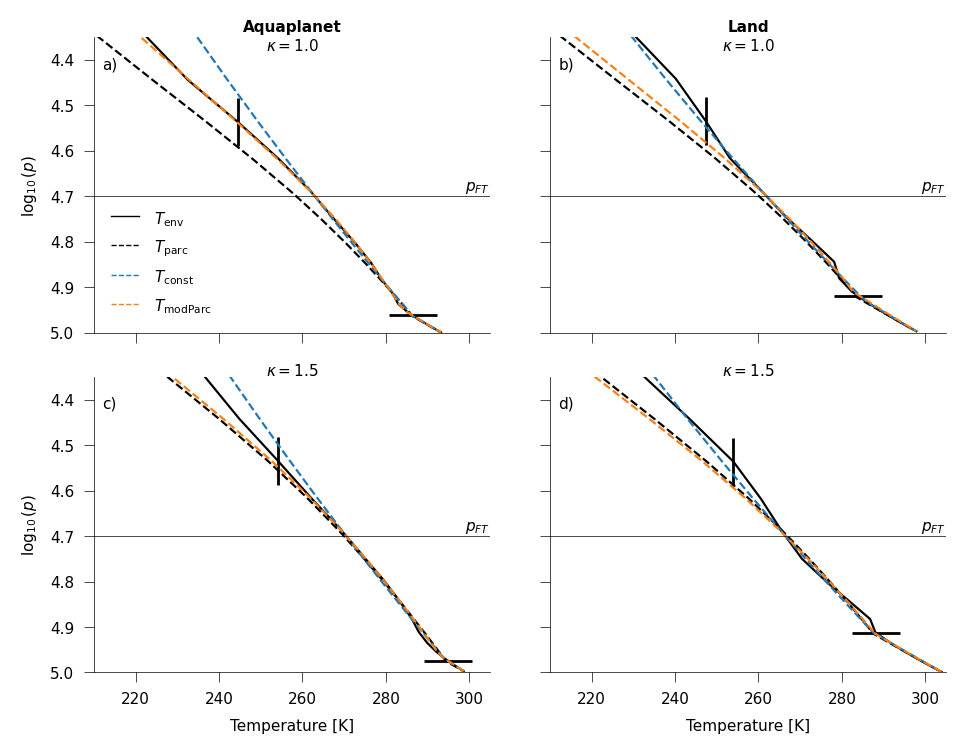

In [85]:
# For some reason won't print and plot in same cell so plot figure here, and printed stuff in next cell
fig

In [80]:
print(cap.stdout)

Surf = Aquaplanet | Kappa = 1.0 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -7299 J/kg
sCAPE: -426.5 J/kg
const params: D=-0.26 K/km | M=4.80 K/km | Error = 18.4% | rh_mod = 0%
mod_parcel params: D=-0.40 K/km | M=-1.43 K/km | Error = 7.5% | rh_mod = -10%
T_parcel error (calc): 22.2% | (ds): 22.2%
Model output CAPE: 36.6 J/kg

Surf = Aquaplanet | Kappa = 1.5 | Lat = 18.1 | x=1
Convflag: 2.0
Epsilon: -1054 J/kg
sCAPE: -46.3 J/kg
const params: D=-1.48 K/km | M=4.58 K/km | Error = 15.0% | rh_mod = -5%
mod_parcel params: D=-1.48 K/km | M=-0.28 K/km | Error = 10.3% | rh_mod = -10%
T_parcel error (calc): 13.9% | (ds): 13.9%
Model output CAPE: 78.9 J/kg

Surf = Land | Kappa = 1.0 | Lat = 18.1 | x=1
Convflag: 1.0
Epsilon: -2682 J/kg
sCAPE: -154.2 J/kg
const params: D=-0.39 K/km | M=5.56 K/km | Error = 16.5% | rh_mod = 5%
mod_parcel params: D=-0.83 K/km | M=-0.34 K/km | Error = 25.2% | rh_mod = -5%
T_parcel error (calc): 27.8% | (ds): 27.8%
Model output CAPE: 17.6 J/kg

Surf = Land | Kappa = 1.5 |

### Fitting Error
Below we show that fitting error better for `mod_parcel` for aquaplanet but not land. Also, that `convflag` closer to 2 for aquaplanet indicating deep convection triggered more.

I use median and IQR for shading because `convflag` takes almost discrete values, so $\pm$ standard deviation shading looks way too big, given
that very few days have `convflag<1`. I.e. $\pm \sigma$ forces symmetric shading, when data is not symmetric about median.

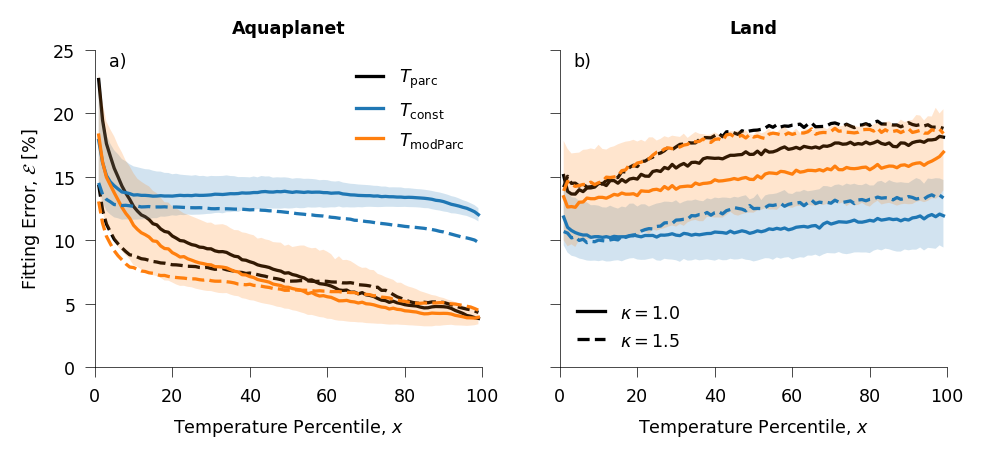

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    lat_weights = np.cos(np.deg2rad(ds_use.lat))
    ax[k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[k].set_xlabel(utils.percentile_label)
    for j in range(ds['aquaplanet'].tau_lw.size):
        for i, key in enumerate(['parcel', 'const', 'mod_parcel']):
            if (j == 0) & (k == 0):
                label_use = "$T_{\\text{" + key.replace('_parcel', 'Parc').replace('el', '') + "}}$"
            elif (key == 'parcel') & (k == 1):
                label_use = f"$\kappa={ds_use.tau_lw[j]:.1f}$"
            else:
                label_use = None
            var = np.abs(
                ds_use[f"{key}_error"].sum(dim='layer') / ds_use[f"{key}_integral"].sum(dim='layer') * 100, ).isel(
                tau_lw=j)
            if key != 'parcel':
                var = var.isel(rh_mod=var.argmin(dim='rh_mod'))
            ax[k].plot(ds_use.quant, np.average(var.quantile(0.5, dim='sample'), axis=1, weights=lat_weights),
                       color=['k', 'C0', 'C1'][i],
                       linestyle=[None, '--'][j], label=label_use, zorder=0 if key == 'parcel' else None)
            if (j == 0) and (key != 'parcel'):
                ax[k].fill_between(ds_use.quant,
                                   np.average(var.quantile(0.25, dim='sample'), axis=1, weights=lat_weights),
                                   np.average(var.quantile(0.75, dim='sample'), axis=1, weights=lat_weights),
                                   alpha=0.2,
                                   color=['k', 'C0', 'C1'][i], edgecolor="none")

update_linewidth(fig, 1.5)
ax[0].set_ylim(0, 25)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('Fitting Error, $\mathcal{E}$ [%]')
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

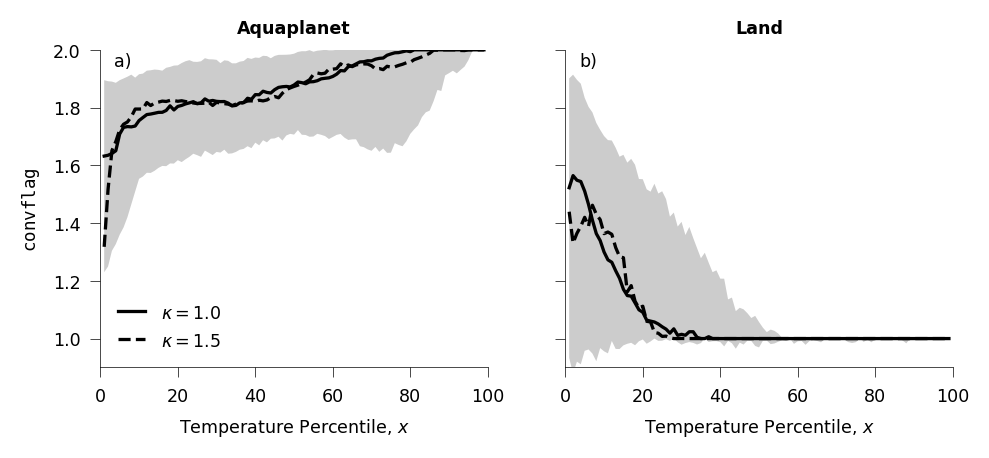

In [9]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    lat_weights = np.cos(np.deg2rad(ds_use.lat))
    ax[k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[k].set_xlabel(utils.percentile_label)
    for j in range(ds['aquaplanet'].tau_lw.size):
        ax[k].plot(ds_use.quant, np.average(ds_use.convflag.quantile(0.5, dim='sample').isel(tau_lw=j), axis=1,
                                            weights=lat_weights),
                   color='k', linestyle=[None, '--'][j], label=f"$\kappa={ds_use.tau_lw[j]:.1f}$")
        if j == 0:
            ax[k].fill_between(ds_use.quant,
                               np.average(ds_use.convflag.isel(tau_lw=j).quantile(0.25, dim='sample'), axis=1,
                                          weights=lat_weights),
                               np.average(ds_use.convflag.isel(tau_lw=j).quantile(0.75, dim='sample'), axis=1,
                                          weights=lat_weights), alpha=0.2,
                               color="k", edgecolor="none")

update_linewidth(fig, 1.5)
ax[0].set_ylim(0.9, 2)
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\mathtt{convflag}$')
ax[0].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig)

### Valid days
Below I plot for the aquaplanet simulation, the days for which `mod_parcel` has lower error than 25% and thus days valid to consider convctive.

For land, very few days are valid so no point proceeding.

In [94]:
surf_plot = 'aquaplanet'
error_thresh = 0.25
# error_thresh2 = 0.1
const_error = np.abs(ds[surf_plot].const_error.sum(dim='layer') / ds[surf_plot].const_integral.sum(dim='layer'))
const_error = const_error.isel(rh_mod=const_error.argmin(dim='rh_mod'))
mod_parcel_error = np.abs(
    ds[surf_plot].mod_parcel_error.sum(dim='layer') / ds[surf_plot].mod_parcel_integral.sum(dim='layer'))
mod_parcel_error = mod_parcel_error.isel(rh_mod=mod_parcel_error.argmin(dim='rh_mod'))
mask_fit = (mod_parcel_error < const_error) & (mod_parcel_error < error_thresh)

# Print total number of days valid
print((mask_fit.sum(dim=['sample', 'quant', 'lat']).values / (
        mask_fit.sample.size * mask_fit.quant.size * mask_fit.lat.size)) * 100)

var = (mask_fit.sum(dim='sample') / mask_fit.sample.size * 100)
print(var.values.min())

# fig, ax = plt.subplots(1, ds['aquaplanet'].tau_lw.size, sharey=True, sharex=True)
# fig_resize(fig, width['two_col'])
# for i in range(ds['aquaplanet'].tau_lw.size):
#     im = var.T.isel(tau_lw=i).plot.imshow(ax=ax[i], cmap='Grays', vmin=20, vmax=100, add_colorbar=False)
#     ax[i].set_xlabel(utils.percentile_label)
#     ax[i].set_title(f"$\kappa={var.tau_lw[i]:.1f}$", y=0.97)
# ax[0].set_ylim(-20, 20)
# ax[0].set_xlim(0, 100)
# ax[0].set_ylabel('Latitude [deg]')
# ax[1].set_ylabel('')
# fig.colorbar(im, ax=ax, label='% convective days')
# label_subplots(fig, ax, box_alpha=0, pos_y=5)
# update_fontsize(fig, 10)
# plt.show()
# isca_tools.savefig(fig)

[82.95787642 88.9947886 ]
20.644599303135887
